Importing the Libraries and Setting Up the Configuration

In [1]:
# !pip install seaborn
# !pip install datawig
# !pip install -U imbalanced-learn
# !pip install numpy --upgrade
# !pip install pandas --upgrade
# !pip install apyori

# # IMPORTANT: Comment and start runtime after executing the code above!

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datawig
from sklearn.preprocessing import minmax_scale, MinMaxScaler
from sklearn.metrics import mean_squared_log_error
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from apyori import apriori

In [3]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/My\ Drive/COMP4433/Competition

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/COMP4433/Competition


Importing the dataset

In [4]:
train = pd.read_csv('train.csv')

In [5]:
test = pd.read_csv('test.csv')

In [6]:
train_test_X = pd.concat([train.iloc[:,:-1], test], ignore_index=True)
train_y = train.iloc[:,-1].copy()

Data Cleaning

In [7]:
# Create 'filled_train_test' dataframe which ALL of the values in its column ('filled_columns') ARE FILLED
filled_columns = train_test_X.columns[~train_test_X.isnull().any()]
filled_train_test = train_test_X[filled_columns].copy()
# Create 'empty_train_test' dataframe which SOME OR ALL of the values of in column ('empty_columns') are NOT FILLED
empty_columns = train_test_X.columns[train_test_X.isnull().any()]
empty_train_test = train_test_X[empty_columns].copy()
# Create 'list_empty_columns_true' list which ALL of the empty values count of in column ARE LESS THAN 365 (= 25% of the row length of the train dataframe)
list_empty_columns_true = train_test_X[empty_columns].isnull().sum().sort_values(ascending=True)
list_empty_columns_true = list_empty_columns_true[list_empty_columns_true <= (0.25*len(train_test_X))]
# Filter the 'empty_train_test' dataframe to ONLY CONTAIN the columns that EXIST in 'list_empty_columns_true' list
empty_train_test = empty_train_test.loc[:, empty_train_test.columns.isin(list_empty_columns_true.keys())]
# Add the 'Id' column from 'train_test_X' dataframe to 'empty_train_test' dataframe
empty_train_test.insert(loc=0, column='Id', value=train_test_X.iloc[:, 0])

In [8]:
dict_plot_rmsle = {}
dict_plot_acc = {}

In [9]:
# Iterate the column name (cols_at_end/predicted column) from the 'list_empty_columns_true' list
for cols_at_end in list_empty_columns_true.index:
  print("####################################")
  print("Current: ", cols_at_end)
  print("####################################")
  # Create 'pd_train_test' dataframe which ALL of the values in 'cols_at_end' column are NOT EMPTY
  pd_train_test = empty_train_test[empty_train_test[cols_at_end].notna()]
  # Rearrange 'pd_train' columns into the following order: column{'Id'} -> dtype{Object/String} -> dtype{Float} -> dtype{Integer} -> column{cols_at_end/predicted column}
  pd_train_test = pd_train_test[[c for c in pd_train_test if c == 'Id']
                      + [c for c in pd_train_test if c not in cols_at_end and pd_train_test[c].dtype == 'O']
                      + [c for c in pd_train_test if c not in cols_at_end and pd_train_test[c].dtype == 'float']
                      + [c for c in pd_train_test if c not in cols_at_end and c != 'Id' and pd_train_test[c].dtype == 'int'] 
                      + [c for c in pd_train_test if c in cols_at_end]]
  # Create 'pd_train_test_train' dataframe which ALL of the values in its columns are NOT EMPTY
  pd_train_test_filled_columns = pd_train_test.columns[~pd_train_test.isnull().any()]
  pd_train_test_train = pd_train_test[pd_train_test_filled_columns]
  pd_train_test_train = pd_train_test_train.drop([cols_at_end], axis=1)
  # Create 'pd_predict' dataframe which ALL of the values in 'cols_at_end' column ARE EMPTY
  pd_predict = empty_train_test[empty_train_test[cols_at_end].isna()]
  # Rearrange 'pd_predict' columns into the following order: column{'Id'} -> dtype{Object/String} -> dtype{Float} -> dtype{Integer} -> column{cols_at_end/predicted column}
  pd_predict = pd_predict[[c for c in pd_predict if c == 'Id']
                          + [c for c in pd_predict if c not in cols_at_end and pd_predict[c].dtype == 'O']
                          + [c for c in pd_predict if c not in cols_at_end and pd_predict[c].dtype == 'float'] 
                          + [c for c in pd_predict if c not in cols_at_end and c != 'Id' and pd_predict[c].dtype == 'int'] 
                          + [c for c in pd_predict if c in cols_at_end]]
  # Create 'pd_predict_train' dataframe which ALL of the values in its columns EXCEPT 'cols_at_end' are NOT EMPTY
  pd_predict_filled_columns = pd_predict.columns[~pd_predict.isnull().any()]
  pd_predict_train = pd_predict[pd_predict_filled_columns]
  # Split 'pd_train_test' and 'pd_predict' dataframes into train ('X_pd_train_test', 'y_pd_train_test') and predict ('X_pd_predict', 'y_pd_predict') dataframes
  X_pd_train_test = pd_train_test.iloc[:, :-1]
  X_pd_predict = pd_predict.iloc[:, :-1]
  y_pd_train_test = pd_train_test.iloc[:, -1]
  y_pd_predict = pd_predict.iloc[:, -1]
  # Create 'list_is_columns_same' list which contains ALL the column names that are identical to the ones in both 'pd_train_test_train' AND 'pd_predict_train' dataframes
  list_is_columns_same = [i for i, j in zip(pd_train_test_train.columns, pd_predict_train.columns) if i == j]
  # Create 'X_pd' dataframe which contains the resulted appending of 'X_pd_train_test' AND 'X_pd_predict' dataframes
  X_pd = X_pd_train_test.append(X_pd_predict)
  # Create 'start_idx_list_float' as a starting column index position AND 'end_idx_list_O' as an ending column index position OF 'X_pd' dataframe
  list_float = [idx for idx,c in enumerate(X_pd) if c not in cols_at_end and c != 'Id' and X_pd[c].dtype == 'float']
  list_O = [idx for idx,c in enumerate(X_pd) if c not in cols_at_end and c != 'Id' and X_pd[c].dtype == 'O']
  start_idx_list_float = list_float[0]
  end_idx_list_O = list_O[-1]
  # Apply feature scaling using min-max normalization on 'X_pd' dataframe
  sc = MinMaxScaler(feature_range=(0,1))
  X_pd.iloc[:, start_idx_list_float:] = sc.fit_transform(X_pd.iloc[:, start_idx_list_float:])
  # Apply feature encoding using one hot 'X_pd' dataframe
  one_hot = pd.get_dummies(X_pd.iloc[:, 1:end_idx_list_O+1])
  X_pd = pd.concat([X_pd, one_hot], axis = 1)
  # Split the 'X_pd' dataframe into train ('X_pd_train_test') and predict ('X_pd_predict') dataframes
  X_pd_train_test = X_pd[:len(X_pd_train_test)]
  X_pd_predict = X_pd[len(X_pd_train_test):]
  # Create 'pd_train_test' and 'pd_predict' dataframes which contain train ('X_pd_train_test', 'y_pd_train_test') and predict ('X_pd_predict', 'y_pd_predict') dataframes
  pd_train_test = X_pd_train_test.join(y_pd_train_test)
  pd_predict = X_pd_predict.join(y_pd_predict)
  # Create 'pd_train_test_train' and 'pd_predict_train' dataframes which contain the random split of 'pd_train_test' dataframe
  pd_train_test_train, pd_predict_train = datawig.utils.random_split(pd_train_test)
  # Predict the missing values in 'cols_at_end' column ON 'pd_predict_train' dataframe
  imputer = datawig.SimpleImputer(
    input_columns=pd_train_test_train.iloc[:, start_idx_list_float:-1].columns, # column(s) containing information about the column we want to impute
    output_column= pd_predict_train.iloc[:, -1].name, # the column we'd like to impute values for
    )
  imputer.fit(train_df=pd_train_test_train.iloc[:,1:])
  imputed = imputer.predict(pd_predict_train.iloc[:,1:])
  # If the predicted value is equal to negative value, replace it with the mean of 'cols_at_end' column values
  if (imputed[cols_at_end+'_imputed'].dtype == 'float') or (imputed[cols_at_end+'_imputed'].dtype == 'int'):
    imputed.reset_index(drop=True)
    count = 0
    for p in imputed[cols_at_end+'_imputed']:
      if p < 0:
        imputed[cols_at_end+'_imputed'].iloc[[count]] = imputed[cols_at_end].mean()
      count+=1
  # Store the RMSLE (numerical column values) AND accuracy (categorical column values) values, which will be used in the visualization stage
  if (pd_train_test.iloc[:, -1].dtype == 'float') or (pd_train_test.iloc[:, -1].dtype == 'int'):
    dw_rmsle = sqrt(mean_squared_log_error(imputed[cols_at_end+'_imputed'],imputed[cols_at_end]))
    dict_plot_rmsle[cols_at_end] = dw_rmsle
  else:
    dw_acc = accuracy_score(imputed[cols_at_end], imputed[cols_at_end+'_imputed'])
    dict_plot_acc[cols_at_end] = dw_acc
  # Predict the missing values in 'cols_at_end' column ON 'pd_predict' dataframe
  imputer = datawig.SimpleImputer(
    input_columns=pd_train_test.iloc[:, start_idx_list_float:-1].columns, # column(s) containing information about the column we want to impute
    output_column= pd_predict.iloc[:, -1].name, # the column we'd like to impute values for
    )
  imputer.fit(train_df=pd_train_test.iloc[:,1:])
  imputed = imputer.predict(pd_predict.iloc[:,1:])
  # If the predicted value is equal to negative value, replace it with the mean of 'cols_at_end' column values
  if (imputed[cols_at_end+'_imputed'].dtype == 'float') or (imputed[cols_at_end+'_imputed'].dtype == 'int'):
    imputed.reset_index(drop=True)
    count = 0
    for p in imputed[cols_at_end+'_imputed']:
      if p < 0:
        imputed[cols_at_end+'_imputed'].iloc[[count]] = pd_train_test[cols_at_end].mean()
      count+=1
  # Store the predicted values in the 'cols_at_end' column ON 'pd_predict' dataframe
  if (pd_train_test.iloc[:, -1].dtype == 'float') or (pd_train_test.iloc[:, -1].dtype == 'int'):
    pd_predict.iloc[:, -1] = imputed.iloc[:,-1]
  else:
    pd_predict.iloc[:, -1] = imputed.iloc[:,-2]
  # Store the predicted values in the 'cols_at_end' column ON 'empty_train_test' dataframe
  for i_predict in pd_predict['Id']:
    for i_empty_train_test in empty_train_test['Id']:
      if (i_predict == i_empty_train_test):
        empty_train_test[cols_at_end].loc[empty_train_test['Id'] == i_empty_train_test] = pd_predict[cols_at_end].loc[pd_predict['Id'] == i_predict].copy()

####################################
Current:  TotalBsmtSF
####################################


2021-11-20 21:18:17,632 [INFO]  
========== start: fit model
2021-11-20 21:18:17,637 [WARNING]  Already bound, ignoring bind()
2021-11-20 21:18:17,715 [INFO]  Epoch[0] Batch [0-66]	Speed: 14728.60 samples/sec	cross-entropy=6.559373	TotalBsmtSF-accuracy=0.000000
2021-11-20 21:18:17,790 [INFO]  Epoch[0] Train-cross-entropy=5.351529
2021-11-20 21:18:17,792 [INFO]  Epoch[0] Train-TotalBsmtSF-accuracy=0.000000
2021-11-20 21:18:17,799 [INFO]  Epoch[0] Time cost=0.158
2021-11-20 21:18:17,810 [INFO]  Saved checkpoint to "totalbsmtsf/model-0000.params"
2021-11-20 21:18:17,821 [INFO]  Epoch[0] Validation-cross-entropy=2.379307
2021-11-20 21:18:17,824 [INFO]  Epoch[0] Validation-TotalBsmtSF-accuracy=0.000000
2021-11-20 21:18:17,898 [INFO]  Epoch[1] Batch [0-66]	Speed: 15344.27 samples/sec	cross-entropy=3.024975	TotalBsmtSF-accuracy=0.000000
2021-11-20 21:18:17,986 [INFO]  Epoch[1] Train-cross-entropy=2.648353
2021-11-20 21:18:17,989 [INFO]  Epoch[1] Train-TotalBsmtSF-accuracy=0.000000
2021-11-20 

####################################
Current:  GarageArea
####################################


/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)


####################################
Current:  GarageCars
####################################


/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)


####################################
Current:  KitchenQual
####################################
####################################
Current:  Electrical
####################################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

####################################
Current:  BsmtUnfSF
####################################


/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)


####################################
Current:  BsmtFinSF2
####################################


/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)


####################################
Current:  BsmtFinSF1
####################################


/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)


####################################
Current:  SaleType
####################################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

####################################
Current:  Exterior1st
####################################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-d

####################################
Current:  Exterior2nd
####################################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

####################################
Current:  Functional
####################################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

####################################
Current:  Utilities
####################################


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


####################################
Current:  BsmtHalfBath
####################################


/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


####################################
Current:  BsmtFullBath
####################################


/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


####################################
Current:  MSZoning
####################################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

####################################
Current:  MasVnrArea
####################################


/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


####################################
Current:  MasVnrType
####################################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: divide by zero encounter

####################################
Current:  BsmtFinType1
####################################


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


####################################
Current:  BsmtFinType2
####################################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is t

####################################
Current:  BsmtQual
####################################


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


####################################
Current:  BsmtCond
####################################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is t

####################################
Current:  BsmtExposure
####################################


/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probas)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


####################################
Current:  GarageType
####################################


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


####################################
Current:  GarageCond
####################################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

####################################
Current:  GarageQual
####################################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is 

####################################
Current:  GarageYrBlt
####################################


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


####################################
Current:  GarageFinish
####################################


/usr/local/lib/python3.7/dist-packages/datawig/calibration.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probas)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


####################################
Current:  LotFrontage
####################################


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
# Update the train dataframe with its new version (the previous empty values are all filled)
train_test_X = pd.merge(empty_train_test, filled_train_test, on="Id")

Association Rule Mining (Apriori)

In [11]:
train_test_copy = train_test_X.iloc[:len(train),:].copy()
train_test_copy['SalePrice'] = train['SalePrice'].copy()

cols_at_end = train_test_copy.iloc[:, -1].name

train_test_copy = train_test_copy[[c for c in train_test_copy if c == 'Id']
              + [c for c in train_test_copy if c in cols_at_end]
              + [c for c in train_test_copy if c not in cols_at_end and train_test_copy[c].dtype == 'float'] 
              + [c for c in train_test_copy if c not in cols_at_end and c != 'Id' and train_test_copy[c].dtype == 'int']
              + [c for c in train_test_copy if c not in cols_at_end and train_test_copy[c].dtype == 'O']]

list_O = [idx for idx,c in enumerate(train_test_copy) if c not in cols_at_end and c != 'Id' and train_test_copy[c].dtype == 'O']

In [12]:
SalePrice_int = train_test_copy['SalePrice'].astype(int)

In [13]:
labels = ["{0} - {1}".format(i, i + (70000-1)) for i in range(SalePrice_int.min(), SalePrice_int.max(), 70000)]
train_test_copy["group_SalePrice"] = pd.cut(SalePrice_int, len(labels), labels=labels)
train_test_copy["group_SalePrice"] = train_test_copy["group_SalePrice"].astype(str)

In [14]:
transactions = train_test_copy.iloc[:,list_O[0]:].values.tolist()

In [15]:
rules = apriori(transactions = transactions, min_support = 0.003, min_confidence = 0.2, min_lift = 3, min_length = 2, max_length = 2)
results = list(rules)

In [16]:
results

[RelationRecord(items=frozenset({'1.5Fin', 'Artery'}), support=0.015068493150684932, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Artery'}), items_add=frozenset({'1.5Fin'}), confidence=0.45833333333333337, lift=4.345238095238096)]),
 RelationRecord(items=frozenset({'1.5Fin', 'AsbShng'}), support=0.005479452054794521, ordered_statistics=[OrderedStatistic(items_base=frozenset({'AsbShng'}), items_add=frozenset({'1.5Fin'}), confidence=0.34782608695652173, lift=3.297571993224167)]),
 RelationRecord(items=frozenset({'1.5Fin', 'BrkSide'}), support=0.017123287671232876, ordered_statistics=[OrderedStatistic(items_base=frozenset({'BrkSide'}), items_add=frozenset({'1.5Fin'}), confidence=0.4310344827586206, lift=4.086430810568741)]),
 RelationRecord(items=frozenset({'1.5Fin', 'BrkTil'}), support=0.03767123287671233, ordered_statistics=[OrderedStatistic(items_base=frozenset({'1.5Fin'}), items_add=frozenset({'BrkTil'}), confidence=0.35714285714285715, lift=3.571428571428571), OrderedS

In [17]:
def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))
resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence', 'Lift'])

In [18]:
resultsinDataFrame[resultsinDataFrame['Left Hand Side'].isin(labels)].sort_values(by=['Support','Confidence','Lift'], ascending=False)

,Left Hand Side,Right Hand Side,Support,Confidence,Lift
35,34900 - 104899,Fa,0.045890,0.544715,3.996405
41,34900 - 104899,N,0.043151,0.512195,4.952350
43,34900 - 104899,RM,0.038356,0.455285,3.049153
36,34900 - 104899,FuseA,0.017123,0.203252,3.156893
47,384900 - 454899,Fin,0.016438,0.774194,3.211144
30,314900 - 384899,Stone,0.014384,0.313433,3.200083
48,384900 - 454899,Hip,0.013699,0.645161,3.293481
29,314900 - 384899,NridgHt,0.013699,0.298507,5.660012
49,384900 - 454899,New,0.012329,0.580645,6.948704
51,384900 - 454899,Partial,0.012329,0.580645,6.781935


In [19]:
resultsinDataFrame[resultsinDataFrame['Right Hand Side'].isin(labels)].sort_values(by=['Support','Confidence','Lift'], ascending=False)

,Left Hand Side,Right Hand Side,Support,Confidence,Lift
22,NoRidge,244900 - 314899,0.012329,0.439024,3.748395
39,IDOTRR,34900 - 104899,0.010959,0.432432,5.132938
33,BrkSide,34900 - 104899,0.010274,0.258621,3.069807
28,NoRidge,314900 - 384899,0.008904,0.317073,6.909356
46,Twnhs,34900 - 104899,0.008904,0.302326,3.588580
40,MeadowV,34900 - 104899,0.008219,0.705882,8.378766
44,Slab,34900 - 104899,0.007534,0.458333,5.440379
37,FuseF,34900 - 104899,0.007534,0.407407,4.835893
31,AsbShng,34900 - 104899,0.006164,0.391304,4.644751
45,Stucco,34900 - 104899,0.006164,0.290323,3.446105


Visualization

In [20]:
dict_plot_rmsle = dict(sorted(dict_plot_rmsle.items(), key=lambda x: x[1]))
dict_plot_acc = dict(sorted(dict_plot_acc.items(), key=lambda x: -x[1]))

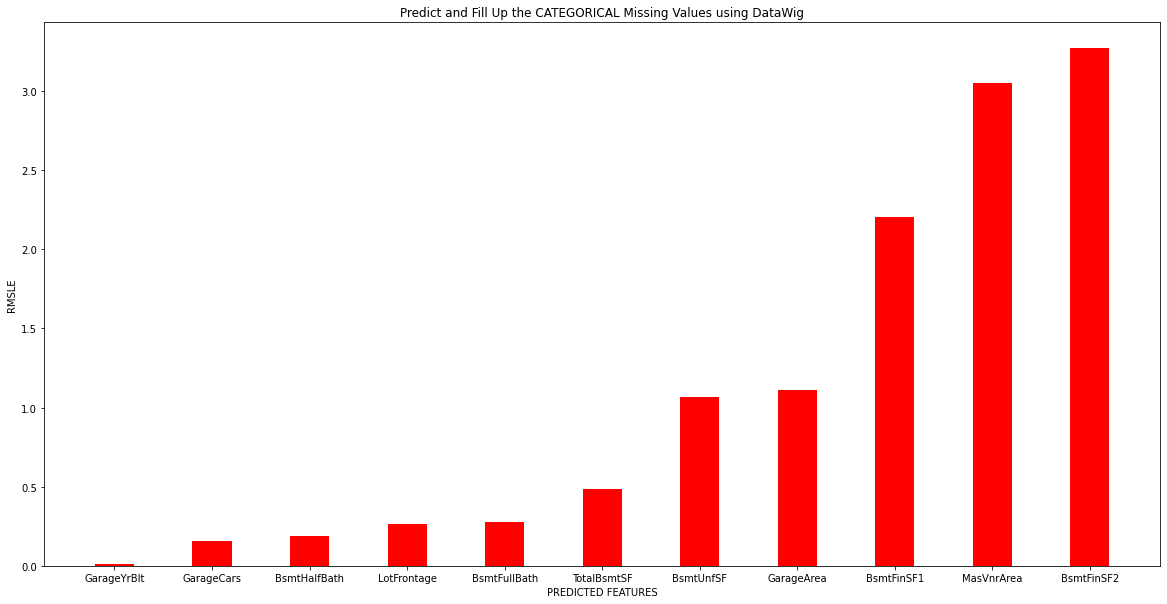

In [21]:
features = list(dict_plot_rmsle.keys())
rmsle = list(dict_plot_rmsle.values())

fig = plt.figure(figsize = (20, 10))
 
# creating the bar plot
plt.bar(features, rmsle, color ='red', width = 0.4)
 
plt.xlabel("PREDICTED FEATURES")
plt.ylabel("RMSLE")
plt.title("Predict and Fill Up the CATEGORICAL Missing Values using DataWig")
plt.show()

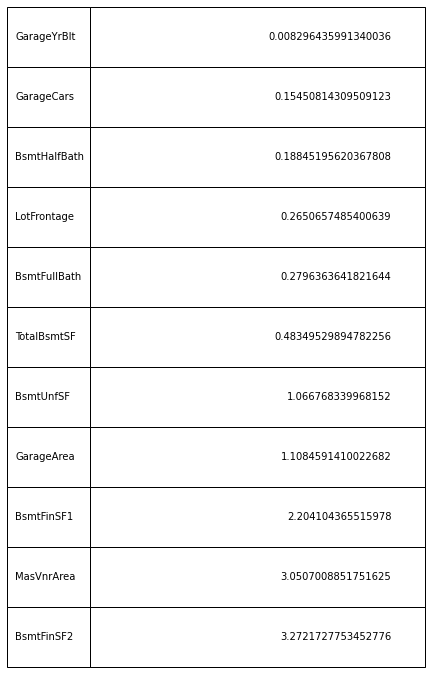

In [22]:
fig, ax = plt.subplots()
features_plot = []
rmsle_plot = []
for r in rmsle:
  rmsle_plot.append([r])
ax.table(rowLabels=features,loc="center", cellText=rmsle_plot).scale(1, 5)
ax.axis('tight')
ax.axis('off')
plt.show()

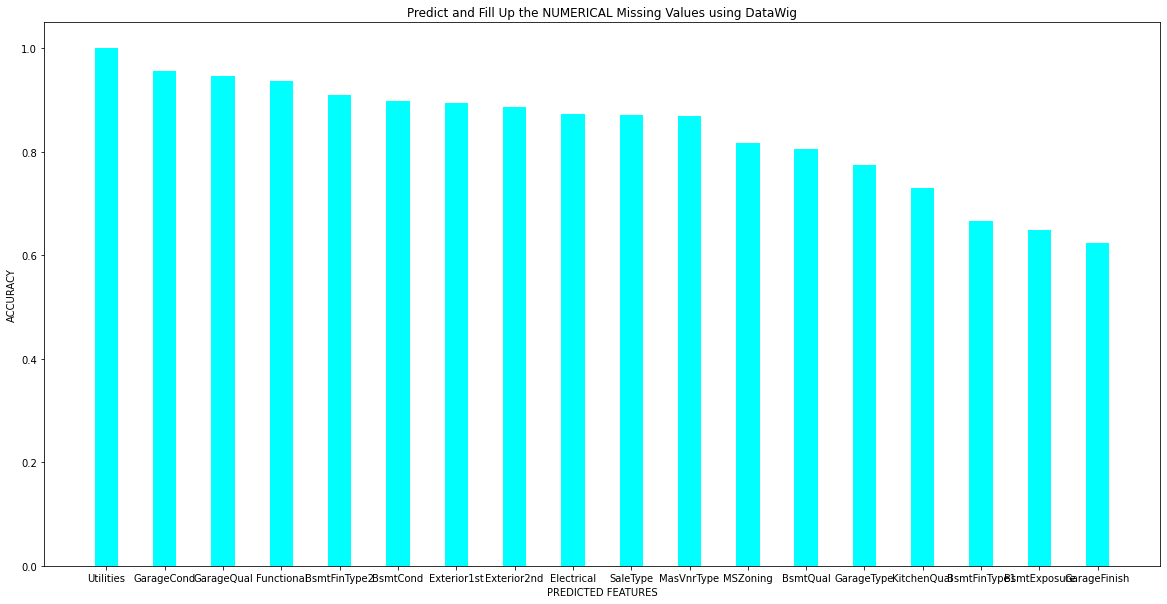

In [23]:
features = list(dict_plot_acc.keys())
acc = list(dict_plot_acc.values())
  
fig = plt.figure(figsize = (20, 10))
 
# creating the bar plot
plt.bar(features, acc, color ='cyan', width = 0.4)
 
plt.xlabel("PREDICTED FEATURES")
plt.ylabel("ACCURACY")
plt.title("Predict and Fill Up the NUMERICAL Missing Values using DataWig")
plt.show()

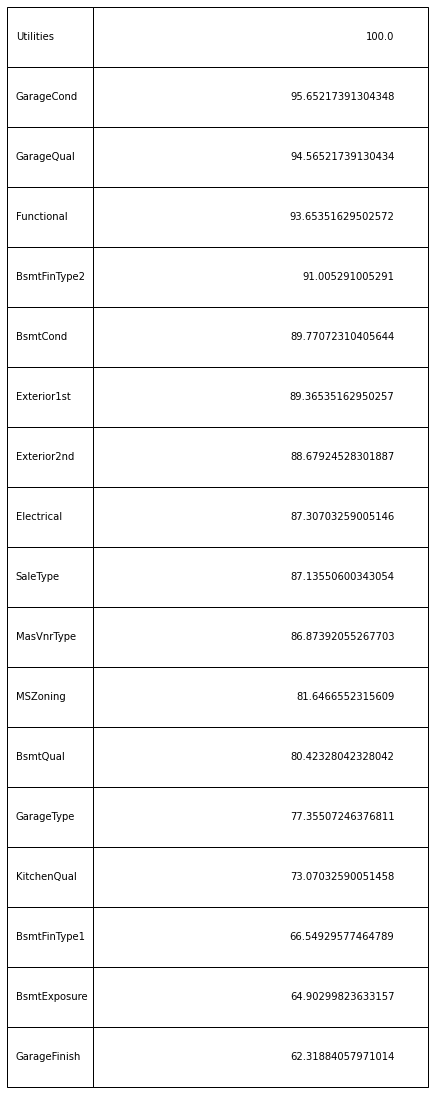

In [24]:
fig, ax = plt.subplots()
features_plot = []
acc_plot = []
for a in acc:
  acc_plot.append([a*100])
ax.table(rowLabels=features,loc="center", cellText=acc_plot).scale(1, 5)
ax.axis('tight')
ax.axis('off')
plt.show()

In [25]:
list_empty_columns_true

TotalBsmtSF       1
GarageArea        1
GarageCars        1
KitchenQual       1
Electrical        1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
SaleType          1
Exterior1st       1
Exterior2nd       1
Functional        2
Utilities         2
BsmtHalfBath      2
BsmtFullBath      2
MSZoning          4
MasVnrArea       23
MasVnrType       24
BsmtFinType1     79
BsmtFinType2     80
BsmtQual         81
BsmtCond         82
BsmtExposure     82
GarageType      157
GarageCond      159
GarageQual      159
GarageYrBlt     159
GarageFinish    159
LotFrontage     486
dtype: int64

In [28]:
train_test_copy_copy = train_test_copy.copy()
train_test_X_copy = train_test_X.copy()

In [29]:
cols_at_end = train_test_copy_copy.iloc[:, -1].name

train_test_X_copy = train_test_X_copy[[c for c in train_test_X_copy if c == 'Id']
                                      + [c for c in train_test_X_copy if train_test_X_copy[c].dtype == 'O']
                                      + [c for c in train_test_X_copy if train_test_X_copy[c].dtype == 'float'] 
                                      + [c for c in train_test_X_copy if c != 'Id' and train_test_X_copy[c].dtype == 'int']]

list_float = [idx for idx,c in enumerate(train_test_X_copy) if train_test_X_copy[c].dtype == 'float']
list_O = [idx for idx,c in enumerate(train_test_X_copy) if train_test_X_copy[c].dtype == 'O']
list_int = [idx for idx,c in enumerate(train_test_X_copy) if c != 'Id' and train_test_X_copy[c].dtype == 'int']
start_idx_list_float = list_float[0]
end_idx_list_float = list_float[-1]
start_idx_list_int = list_float[0]
end_idx_list_int = list_float[-1]
start_idx_list_O = list_O[0]
end_idx_list_O = list_O[-1]

sc_y = MinMaxScaler(feature_range=(0,1))
y = train_test_copy_copy.iloc[:,1].values.reshape(-1, 1)
y = sc_y.fit_transform(y)

one_hot = pd.get_dummies(train_test_X_copy.iloc[:, start_idx_list_O:end_idx_list_O+1])
end_idx_np_float = one_hot.shape[1]-1

sc_X = MinMaxScaler(feature_range=(0,1))
X = sc_X.fit_transform(train_test_X_copy.iloc[:, start_idx_list_float:end_idx_list_int+1])

X = np.concatenate([one_hot,X], axis = 1)

In [30]:
X_train = X[:len(train)]
X_test = X[len(train):]

Predictive Analytics

- https://www.researchgate.net/post/What-do-you-consider-a-good-standard-deviation

- Support Vector Regression
- Polynomial Regression
- Decision Tree Regression
- Random Forest Regression
- Neural Network Regression
- K-Nearest Neighbour
- Gaussian Process regression
- XGBoost Regressor

In [31]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import math
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [32]:
dict_plot_rmsle = {}
dict_plot_std = {}
dict_best_hyperparams = {}

# define evaluation
# cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
# cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1)
# cv = 10
cv = 5

In [33]:
def rmsle_score(preds, true):
    rmsle_score = (np.sum((np.log1p(preds)-np.log1p(true))**2)/len(true))**0.5
    return rmsle_score

In [34]:
def get_cv_scores_rmsle(model):
    scores = cross_val_score(model,
                             X_train,
                             y.ravel(),
                             scoring=make_scorer(rmsle_score),
                             cv=cv)
    
    print('CV Mean: ', np.mean(scores))
    dict_plot_rmsle[type(model).__name__] = np.mean(scores)
    print('STD: ', np.std(scores))
    dict_plot_std[type(model).__name__] = np.std(scores)
    print('\n')

Support Vector Regressor

In [35]:
from sklearn.svm import SVR
regressor_SVR = SVR()

In [36]:
# define search
parameters = [{'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}]
search_SVR = GridSearchCV(regressor_SVR, param_grid = parameters, scoring=make_scorer(rmsle_score), n_jobs=-1, cv=cv)
result = search_SVR.fit(X_train, y.ravel())
# summarize result
print('Best Hyperparameters: %s' % result.best_params_)
dict_best_hyperparams[type(regressor_SVR).__name__] =  result.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [0.08894104 0.04983143 0.08633033 0.06031903 0.04983143 0.07175781
 0.05286074 0.06517414 0.05523635 0.06527174 0.0862487  0.06970506
 0.09224507 0.04983143 0.08633033 0.05936652 0.04983143        nan
 0.04849964 0.05367371 0.04766732 0.0515379  0.08551188 0.0549323
 0.09224507 0.04983143 0.08633032 0.05936652 0.04983143        nan
 0.05071926 0.0500089  0.16110708 0.04791984 0.08032525 0.04794711
 0.09224507 0.04983143 0.08633028 0.05936652 0.04983143        nan
 0.05071926 0.04983143        nan 0.05386234 0.06517414 0.05181054]
  category=UserWarning,


Best Hyperparameters: {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}


Neural Network Regressor

In [37]:
from sklearn.neural_network import MLPRegressor
regressor_MLPRegressor = MLPRegressor()

In [38]:
# define search
parameters = [{'activation': ['relu', 'tanh', 'logistic', 'identity'],
          'hidden_layer_sizes': [(100,), (50,100,), (50,75,100,)],
          'solver': ['adam', 'sgd', 'lbfgs'],
          'learning_rate' : ['constant', 'adaptive']
         }]
search_MLPRegressor = GridSearchCV(regressor_MLPRegressor, param_grid = parameters, scoring=make_scorer(rmsle_score), n_jobs=-1, cv=cv)
result = search_MLPRegressor.fit(X_train, y.ravel())
# summarize result
print('Best Hyperparameters: %s' % result.best_params_)
dict_best_hyperparams[type(regressor_MLPRegressor).__name__] =  result.best_params_

Best Hyperparameters: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}


Decision Tree Regressor

In [39]:
from sklearn.tree import DecisionTreeRegressor
regressor_DecisionTreeRegressor = DecisionTreeRegressor()

In [40]:
# define search
parameters=[{"splitter":["best","random"],
            "max_depth" : [5, 7, 11, 13],
            "min_samples_leaf":[3, 5, 7, 9],
            "min_weight_fraction_leaf":[0, 0.25, 0.5],
            "max_features":["auto","log2","sqrt",None],
            "max_leaf_nodes":[20, 60, 80, 100] }]
search_DecisionTreeRegressor = GridSearchCV(regressor_DecisionTreeRegressor, param_grid = parameters, scoring=make_scorer(rmsle_score), n_jobs=-1, cv=cv)
result = search_DecisionTreeRegressor.fit(X_train, y.ravel())
# summarize result
print('Best Hyperparameters: %s' % result.best_params_)
dict_best_hyperparams[type(regressor_DecisionTreeRegressor).__name__] =  result.best_params_

Best Hyperparameters: {'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.5, 'splitter': 'random'}


Random Forest Regressor

In [41]:
from sklearn.ensemble import RandomForestRegressor
regressor_RandomForestRegressor = RandomForestRegressor()

In [42]:
# define search
parameters=[{'bootstrap': [True, False],
            'max_depth': [5, 7, 11],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [3, 5, 7],
            'min_samples_split': [4, 8],
            'n_estimators': [25, 50] }]
search_RandomForestRegressor = GridSearchCV(regressor_RandomForestRegressor, param_grid = parameters, scoring=make_scorer(rmsle_score), n_jobs=-1, cv=cv)
result = search_RandomForestRegressor.fit(X_train, y.ravel())
# summarize result
print('Best Hyperparameters: %s' % result.best_params_)
dict_best_hyperparams[type(regressor_RandomForestRegressor).__name__] =  result.best_params_

Best Hyperparameters: {'bootstrap': False, 'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 25}


K-Nearest Neighbour Regressor

In [43]:
from sklearn.neighbors import KNeighborsRegressor
regressor_KNeighborsRegressor = KNeighborsRegressor()

In [44]:
# define search
parameters = [{'weights': ['uniform', 'distance'], 
               'n_neighbors': [20, 60, 100]}]
search_KNeighborsRegressor = GridSearchCV(regressor_KNeighborsRegressor, param_grid = parameters, scoring=make_scorer(rmsle_score), n_jobs=-1, cv=cv)
result = search_KNeighborsRegressor.fit(X_train, y.ravel())
# summarize result
print('Best Hyperparameters: %s' % result.best_params_)
dict_best_hyperparams[type(regressor_KNeighborsRegressor).__name__] =  result.best_params_

Best Hyperparameters: {'n_neighbors': 100, 'weights': 'uniform'}


Gaussian Process Regressor

In [45]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct
regressor_GaussianProcessRegressor = GaussianProcessRegressor()

In [46]:
# define search
parameters = [{
    "alpha":  [1e-2, 1e-3],
    "kernel": [RBF(l) for l in np.logspace(-1, 1, 2)]
}, {
    "alpha":  [1e-2, 1e-3],
    "kernel": [DotProduct(sigma_0) for sigma_0 in np.logspace(-1, 1, 2)]
}]
search_GaussianProcessRegressor = GridSearchCV(regressor_GaussianProcessRegressor, param_grid = parameters, scoring=make_scorer(rmsle_score), n_jobs=-1, cv=cv)
result = search_GaussianProcessRegressor.fit(X_train, y.ravel())
# summarize result
print('Best Hyperparameters: %s' % result.best_params_)
dict_best_hyperparams[type(regressor_GaussianProcessRegressor).__name__] =  result.best_params_

Best Hyperparameters: {'alpha': 0.001, 'kernel': DotProduct(sigma_0=0.1)}


XGBoost Regressor

In [47]:
from xgboost import XGBRegressor
regressor_XGBRegressor = XGBRegressor()

In [48]:
# define search
parameters = [ {"max_depth": [max_depth for max_depth in range(9,12)],
                "min_child_weight": [min_child_weight for min_child_weight in range(5,8)], 
                "objective": ['reg:squarederror'] 
 } ]
search_XGBRegressor = GridSearchCV(regressor_XGBRegressor, param_grid = parameters, scoring=make_scorer(rmsle_score), n_jobs=-1, cv=cv)
result = search_XGBRegressor.fit(X_train, y.ravel())
# summarize result
print('Best Hyperparameters: %s' % result.best_params_)
dict_best_hyperparams[type(regressor_XGBRegressor).__name__] =  result.best_params_

Best Hyperparameters: {'max_depth': 11, 'min_child_weight': 6, 'objective': 'reg:squarederror'}


In [49]:
for keys in dict_best_hyperparams.keys():
    dict_best_hyperparams[keys] = str(dict_best_hyperparams[keys])

In [50]:
dict_best_hyperparams

{'DecisionTreeRegressor': "{'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.5, 'splitter': 'random'}",
 'GaussianProcessRegressor': "{'alpha': 0.001, 'kernel': DotProduct(sigma_0=0.1)}",
 'KNeighborsRegressor': "{'n_neighbors': 100, 'weights': 'uniform'}",
 'MLPRegressor': "{'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}",
 'RandomForestRegressor': "{'bootstrap': False, 'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 25}",
 'SVR': "{'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}",
 'XGBRegressor': "{'max_depth': 11, 'min_child_weight': 6, 'objective': 'reg:squarederror'}"}

Model Evaluation

In [62]:
regressor_SVR = SVR(C= 10, gamma= 0.01, kernel= 'sigmoid').fit(X_train, y.ravel())
get_cv_scores_rmsle(regressor_SVR)

CV Mean:  0.16110708151747027
STD:  0.13253594084677467




In [63]:
regressor_MLPRegressor = MLPRegressor(activation='relu', hidden_layer_sizes=(100,), learning_rate= 'constant', solver= 'sgd').fit(X_train, y.ravel())
get_cv_scores_rmsle(regressor_MLPRegressor)

CV Mean:  0.11257868384210241
STD:  0.00770386725320005




In [64]:
regressor_DecisionTreeRegressor = DecisionTreeRegressor(max_depth= 5, max_features= 'log2', max_leaf_nodes= 20, min_samples_leaf= 3, min_weight_fraction_leaf= 0.5, splitter= 'random').fit(X_train, y.ravel())
get_cv_scores_rmsle(regressor_DecisionTreeRegressor)

CV Mean:  0.0859695133245385
STD:  0.004643700950599636




In [65]:
regressor_RandomForestRegressor = RandomForestRegressor(bootstrap= False, max_depth= 11, max_features= 'auto', min_samples_leaf= 3, min_samples_split= 4, n_estimators= 25).fit(X_train, y.ravel())
get_cv_scores_rmsle(regressor_RandomForestRegressor)

CV Mean:  0.050605647478438376
STD:  0.002494779293481288




In [66]:
regressor_KNeighborsRegressor = KNeighborsRegressor(n_neighbors= 100, weights= 'uniform').fit(X_train, y.ravel())
get_cv_scores_rmsle(regressor_KNeighborsRegressor)

CV Mean:  0.052294604284692216
STD:  0.0048452661108487425




In [67]:
regressor_GaussianProcessRegressor = GaussianProcessRegressor(alpha= 0.001, kernel= DotProduct(sigma_0=0.1)).fit(X_train, y.ravel())
get_cv_scores_rmsle(regressor_GaussianProcessRegressor)

CV Mean:  0.03895177446851341
STD:  0.006376129837225




In [68]:
regressor_XGBRegressor = XGBRegressor(max_depth= 11, min_child_weight= 6, objective='reg:squarederror').fit(X_train, y.ravel())
get_cv_scores_rmsle(regressor_XGBRegressor)

CV Mean:  0.03515858957232358
STD:  0.004764888571874359




In [69]:
dict_plot_rmsle

{'DecisionTreeRegressor': 0.0859695133245385,
 'GaussianProcessRegressor': 0.03895177446851341,
 'KNeighborsRegressor': 0.052294604284692216,
 'MLPRegressor': 0.11257868384210241,
 'RandomForestRegressor': 0.050605647478438376,
 'SVR': 0.16110708151747027,
 'XGBRegressor': 0.03515858957232358}

In [70]:
dict_plot_std

{'DecisionTreeRegressor': 0.004643700950599636,
 'GaussianProcessRegressor': 0.006376129837225,
 'KNeighborsRegressor': 0.0048452661108487425,
 'MLPRegressor': 0.00770386725320005,
 'RandomForestRegressor': 0.002494779293481288,
 'SVR': 0.13253594084677467,
 'XGBRegressor': 0.004764888571874359}

In [71]:
pd_model_performance = pd.DataFrame({'Root_Mean_Squared_Log_Error':pd.Series(dict_plot_rmsle),'Standard_Deviation':pd.Series(dict_plot_std)}).sort_values(by=['Root_Mean_Squared_Log_Error', 'Standard_Deviation'])

In [72]:
pd_model_performance

,Root_Mean_Squared_Log_Error,Standard_Deviation
XGBRegressor,0.035159,0.004765
GaussianProcessRegressor,0.038952,0.006376
RandomForestRegressor,0.050606,0.002495
KNeighborsRegressor,0.052295,0.004845
DecisionTreeRegressor,0.085970,0.004644
MLPRegressor,0.112579,0.007704
SVR,0.161107,0.132536


Predict on Test Dataset [with XGBRegressor]

In [73]:
y_pred = sc_y.inverse_transform(regressor_XGBRegressor.predict(X_test).reshape(-1,1))

In [75]:
predicted_prices = pd.DataFrame({'Id': test.Id})
predicted_prices['SalePrice'] = y_pred.astype(int)

In [76]:
predicted_prices

,Id,SalePrice
0,1461,132704
1,1462,158344
2,1463,195763
3,1464,192488
4,1465,192094
...,...,...
1454,2915,90233
1455,2916,84800
1456,2917,140051
1457,2918,119041


In [77]:
predicted_prices.to_csv('submission.csv', index=False)